# Chapter 6: Generative Adversarial Networks (GANs) and Game Theory

In this chapter, we delve into the fascinating world of Generative Adversarial Networks (GANs), a groundbreaking approach in the field of machine learning that has opened up new possibilities in image generation, style transfer, data augmentation, and beyond. At their core, GANs involve a unique setup featuring two neural networks—the Generator and the Discriminator—engaged in a continuous game of cat and mouse, learning from each other's strategies to improve their capabilities.

## The GAN Framework

GANs operate on a simple yet powerful principle. The Generator network takes random noise as input and generates data (such as images) that resemble the training data. The Discriminator network, on the other hand, evaluates the data it receives and attempts to distinguish between "real" data (drawn from the training set) and "fake" data (produced by the Generator). Through training, the Generator learns to produce more realistic data, while the Discriminator becomes better at telling real data from fake.

### The Generator

The Generator's goal is to create data that is indistinguishable from genuine data. It starts with a random noise vector and transforms it into a data instance. The Generator continuously refines its output based on feedback from the Discriminator, aiming to fool it into believing that the generated data is real.

### The Discriminator

The Discriminator acts as a judge, evaluating the authenticity of the data it reviews. It takes both real data from the training set and fake data from the Generator as input and learns to classify them correctly as "real" or "fake." The Discriminator's performance informs the Generator about the quality of its output, guiding its learning process.

## Training GANs

Training GANs involves an iterative process where both networks learn simultaneously:

1. **Train the Discriminator**: Hold the Generator constant and update the Discriminator by alternating between real and fake data.
2. **Train the Generator**: Freeze the Discriminator and update the Generator based on its ability to deceive the Discriminator.

This training process is akin to a game where both players continuously adapt and improve their strategies. The end goal is to reach a point where the Generator produces data so realistic that the Discriminator cannot distinguish it from real data, indicating that the Generator has learned the underlying data distribution.

## Challenges and Considerations

Training GANs presents unique challenges, including mode collapse, where the Generator produces a limited variety of outputs, and training instability, where the networks fail to converge to a useful solution. Researchers have developed various strategies and architectures to address these issues, such as Wasserstein GANs (WGANs) and Conditional GANs (cGANs), each offering improvements and new capabilities.

## Conclusion

Generative Adversarial Networks represent a significant leap forward in our ability to generate realistic, high-quality synthetic data. By understanding the principles and challenges of GANs, we unlock the potential to revolutionize fields ranging from art and design to medical imaging and beyond.

In the following sections, we will implement a basic GAN from scratch, explore its training dynamics, and witness the power of generative models in action.

In [1]:
# Import the MNIST dataset from Keras' dataset collection. 
# MNIST is a classic dataset of handwritten digits used for benchmarking models.
from tensorflow.keras.datasets import mnist

# Import the Model and Sequential classes from Keras. 
# Model is the basic class for specifying and training a neural network. 
# Sequential is a linear stack of layers, useful for creating simple models.
from tensorflow.keras.models import Model, Sequential

# Import the Adam optimizer from Keras. 
# Adam is a popular optimization algorithm that's used for training neural networks.
from tensorflow.keras.optimizers import Adam

# Import various layers from Keras that are needed to construct neural networks.
# Dense is a fully connected layer, commonly used in neural networks.
# LeakyReLU is an activation function that allows a small gradient when the unit is not active.
# Dropout is a regularization technique where input units are randomly set to 0 at each update during training time, which helps prevent overfitting.
# Flatten is used to flatten the input, making it a single long vector.
# Input is used to instantiate a Keras tensor, a starting layer for models.
# Reshape is used to reshape the input as per the given shape.
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Flatten, Input, Reshape

# Import NumPy, a fundamental package for scientific computing in Python. 
# It's used for working with arrays and matrices, among other mathematical functions.
import numpy as np

# Import pyplot from matplotlib, a plotting library. 
# It's used here for visualizing images and plotting graphs to analyze the results.
import matplotlib.pyplot as plt

In [2]:
# Load the MNIST dataset from Keras. The MNIST dataset consists of 60,000 28x28 grayscale images of handwritten digits (0-9),
# along with a test set of 10,000 images. Here, we're only interested in the training images (`x_train`),
# so we disregard the labels (`_`) and the test set by assigning them to `_`.
(x_train, _), (_, _) = mnist.load_data()

# Normalize the images to have values in the range [-1, 1]. This normalization step helps in stabilizing the training process
# and often leads to faster convergence. The original images are grayscale with pixel values in the range [0, 255],
# so subtracting 127.5 then dividing by 127.5 shifts the values to [-1, 1].
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

# Flatten the images from a 28x28 matrix to a 784-dimensional vector because the input layer of our network expects
# a one-dimensional vector for each image. The total number of images remains the same (`x_train.shape[0]`),
# but each image is now represented as a vector of length 784 (28*28).
training_data = x_train.reshape(x_train.shape[0], 784)

# Print the shape of the training data to verify its dimensions. It should be (60000, 784),
# indicating there are 60,000 samples, each being a 784-dimensional vector.
print(f"Training data shape: {training_data.shape}")

Training data shape: (60000, 784)


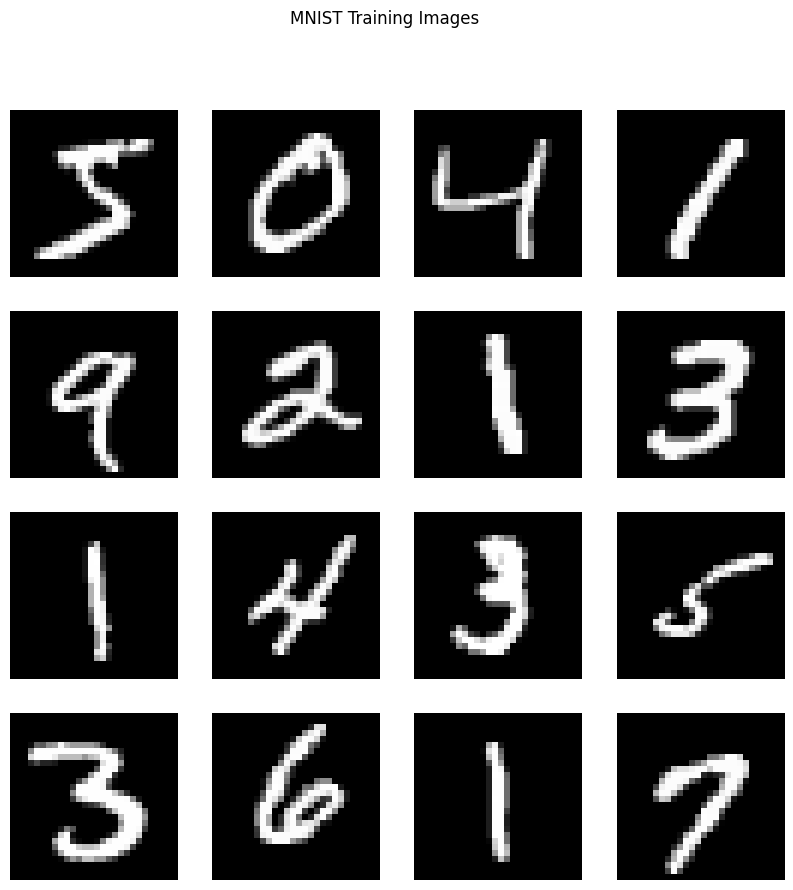

In [3]:
# Define a function for plotting a grid of images.
def plot_images(images, title):
    # Initialize a plot with a specified size.
    plt.figure(figsize=(10, 10))
    # Loop over the first 16 images in the provided array.
    for i in range(16):
        # Add a subplot in a grid of 4x4 at position i+1.
        plt.subplot(4, 4, i+1)
        # Reshape the i-th image to 28x28 and plot it in grayscale.
        # The images need to be reshaped because they were flattened earlier for training.
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        # Remove axis labels to improve visual clarity.
        plt.axis('off')
    # Set the title of the plot, which is passed as an argument to the function.
    plt.suptitle(title)
    # Display the plot.
    plt.show()

# Use the plot_images function to display a subset of the MNIST training images.
# 'x_train' contains the training images, and "MNIST Training Images" is the title for the plot.
plot_images(x_train, "MNIST Training Images")

In [4]:
# This function builds the generator model for a GAN. The generator aims to generate realistic-looking images (or data) from random noise.
def build_generator(z_size, g_hidden_size, g_output_size):
    # Initialize a sequential model. Sequential models in Keras are linear stacks of layers.
    model = Sequential([
        # The first layer is an Input layer specifying the shape of the input noise vector.
        Input(shape=(z_size,)),
        
        # Add a fully connected (Dense) layer with 'g_hidden_size' units.
        # This layer will start processing the random noise.
        Dense(g_hidden_size),
        # LeakyReLU activation allows a small, non-zero gradient when the unit is not active,
        # helping prevent dead neurons and improving the flow of gradients.
        # The 'negative_slope' parameter controls the angle of the 'leaky' part of the function.
        LeakyReLU(negative_slope=0.2),
        # Dropout is a regularization technique that helps prevent overfitting by randomly setting
        # a fraction of input units to 0 at each update during training time.
        Dropout(0.3),
        
        # Additional layers repeat the pattern of Dense -> LeakyReLU -> Dropout,
        # progressively increasing the number of units in each Dense layer.
        Dense(g_hidden_size * 2),
        LeakyReLU(negative_slope=0.2),
        Dropout(0.3),
        
        Dense(g_hidden_size * 4),
        LeakyReLU(negative_slope=0.2),
        Dropout(0.3),
        
        # The final layer is another Dense layer with units equal to 'g_output_size',
        # which corresponds to the size of the generated images (e.g., 784 for a flattened 28x28 image).
        # The 'tanh' activation function is used here, which outputs values in the range [-1, 1],
        # matching the preprocessing applied to the training images.
        Dense(g_output_size, activation='tanh')
    ])
    
    # Return the constructed model. At this point, the model is built but not yet trained.
    return model

In [5]:
# This function builds the discriminator model for a GAN. The discriminator's job is to distinguish between real images (from the dataset) and fake images (generated by the generator).
def build_discriminator(input_size, d_hidden_size, d_output_size):
    # Initialize a sequential model. Sequential models in Keras are composed of a linear stack of layers.
    model = Sequential([
        # The first layer is an Input layer specifying the shape of the input data, which corresponds to the flattened image size.
        Input(shape=(input_size,)),  # Input layer for the image
        
        # A fully connected (Dense) layer with units equal to four times the hidden size. 
        # This serves as the first layer of processing for distinguishing images.
        Dense(d_hidden_size * 4),
        # LeakyReLU activation function is used to allow a small, non-zero gradient when the unit is not active, 
        # which can help maintain gradient flow during training.
        LeakyReLU(negative_slope=0.2),
        # Dropout is applied to help prevent overfitting by randomly setting a portion of input units to 0 at each update during training time.
        Dropout(0.3),
        
        # The pattern of Dense -> LeakyReLU -> Dropout is repeated with progressively decreasing 
        # number of units in each Dense layer, focusing the model's learning capacity.
        Dense(d_hidden_size * 2),
        LeakyReLU(negative_slope=0.2),
        Dropout(0.3),
        
        Dense(d_hidden_size),
        LeakyReLU(negative_slope=0.2),
        Dropout(0.3),
        
        # The final layer is another Dense layer with units equal to 'd_output_size', 
        # which is typically 1 for binary classification (real vs. fake).
        # The 'sigmoid' activation function outputs a probability between 0 and 1, representing the discriminator's confidence in its classification.
        Dense(d_output_size, activation='sigmoid')  # Output layer for binary classification
    ])
    
    # The constructed model is returned. It is ready for compilation and training, but not yet trained.
    return model

In [6]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [7]:
# Build the generator with specified hyperparameters
generator = build_generator(z_size=z_size, g_hidden_size=g_hidden_size, g_output_size=g_output_size)
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,800 (448.44 KB)

 Trainable params: 114,800 (448.44 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Build the discriminator with specified hyperparameters
discriminator = build_discriminator(input_size=input_size, d_hidden_size=d_hidden_size, d_output_size=d_output_size)
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,849 (433.00 KB)

 Trainable params: 110,849 (433.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Import the Sequence class from Keras utilities. Sequence is a base object for fitting to a sequence of data, such as a dataset.
# It provides a way to create data generators that can be used with the Keras `fit` method, particularly useful for custom data loading,
# preprocessing, and augmentation. Using Sequence ensures your data generator is multiprocessing-safe, which is crucial for efficient
# training with Keras when using the `workers` parameter in `fit`.
from tensorflow.keras.utils import Sequence

# Import the Callback class from Keras callbacks. Callbacks are an important part of training deep learning models with Keras.
# They allow you to specify actions to be taken at various stages of training (e.g., at the start or end of an epoch, before or after a single batch,
# etc.). This can include actions like adjusting the learning rate over time, saving model checkpoints, logging metrics, or early stopping
# if the model's performance on a validation set stops improving. Callbacks provide a powerful tool to customize the training loop and
# monitor the model's training process.
from tensorflow.keras.callbacks import Callback

In [10]:
# This custom data generator inherits from Keras's Sequence class, ensuring that our data feeding process into the model is safe for use with multiprocessing.
# It's designed to feed both real and generated (fake) images into the discriminator for training.
class GANDataGenerator(Sequence):
    def __init__(self, real_images, batch_size, z_size, generator, **kwargs):
        super().__init__(**kwargs)  # Calls the constructor of the parent class, Sequence.
        self.real_images = real_images  # Array of real images from the dataset.
        self.batch_size = batch_size  # Number of images to be included in each batch.
        self.z_size = z_size  # Dimensionality of the random noise vector.
        self.generator = generator  # The generator model that produces fake images.

    def __len__(self):
        # Determines the number of steps per epoch by dividing the total number of images by the batch size.
        return len(self.real_images) // self.batch_size

    def __getitem__(self, index):
        # Generates and returns a batch of data (both real and fake images along with their labels) when requested during training.
        noise = np.random.normal(0, 1, (self.batch_size, self.z_size))  # Generate random noise.
        real_imgs = self.real_images[index * self.batch_size:(index + 1) * self.batch_size]  # Slice a batch of real images.
        fake_imgs = self.generator.predict(noise, verbose=0)  # Use the generator to create fake images from noise.
        x = np.concatenate([real_imgs, fake_imgs])  # Combine real and fake images into one batch.
        real_labels = np.ones((self.batch_size, 1))  # Label real images as 1.
        fake_labels = np.zeros((self.batch_size, 1))  # Label fake images as 0.
        y = np.concatenate([real_labels, fake_labels])  # Combine labels.
        return x, y

# This callback is intended to keep a log of discriminator and generator losses throughout the training process.
class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        # Initialize or reset the losses dict at the beginning of training.
        self.losses = {'d_loss': [], 'g_loss': []}

    def on_epoch_end(self, epoch, logs=None):
        # Append the losses logged in the `logs` dict to the respective lists.
        # This assumes that 'loss' corresponds to the discriminator's loss and
        # 'g_loss' is explicitly set in the logs dict by the `TrainGeneratorCallback`.
        if logs is not None:
            self.losses['d_loss'].append(logs.get('loss'))
            self.losses['g_loss'].append(logs.get('g_loss'))

# This callback focuses on training the generator at the end of each epoch and logs its loss.
class TrainGeneratorCallback(Callback):
    def __init__(self, generator, combined, z_size, batch_size):
        super().__init__()
        self.generator = generator
        self.combined = combined
        self.z_size = z_size
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        # Generate noise.
        noise = np.random.normal(0, 1, (self.batch_size * 2, self.z_size))
        misleading_targets = np.ones((self.batch_size * 2, 1))
        
        # Train the generator via the combined model for one epoch.
        # Note: Using `fit` here, which returns a History object. We'll extract the loss from this object.
        history = self.combined.fit(noise, misleading_targets, batch_size=self.batch_size, epochs=1, verbose=0)
        
        # Extract the generator's loss. You can choose to take the last batch's loss, or the average loss over the epoch.
        # Here, we take the loss from the last batch as it's a single epoch training.
        g_loss = history.history['loss'][-1]
        
        # Ensure `logs` is a dict to avoid TypeErrors during callback execution.
        if logs is None:
            logs = {}
        
        # Update the logs dict with the generator's loss.
        logs['g_loss'] = g_loss

In [11]:
# Define the dimensionality of the latent space (noise vector) used as input to the generator.
z_size = 100

# Input layer specifying the shape of the noise vector.
z = Input(shape=(z_size,))
# The generator model takes the noise vector 'z' as input and generates an image.
img = generator(z)
# Freeze the discriminator weights when training the generator within the combined model.
discriminator.trainable = False
# Pass the generated image through the discriminator to get the validity score.
validity = discriminator(img)

# Before defining the combined model, ensure the discriminator is compiled with the correct settings for standalone training.
# This ensures that when we compile the discriminator on its own, its weights are updated correctly.
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Define the combined model that chains together the generator and discriminator.
# This model will be used to train the generator to fool the discriminator.
combined = Model(inputs=z, outputs=validity)
# Compile the combined model with binary crossentropy loss and the Adam optimizer.
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training hyperparameters
epochs = 100
batch_size = 128
sample_size = 16  # Number of images to generate for viewing progress. Ensure to use this for generating and plotting images.

# Instantiate the custom callbacks and the data generator.
# The data generator is passed 'batch_size//2' because each training batch will contain an equal mix of real and generated images.
# This halves the batch size for each type (real and fake), ensuring balanced training for the discriminator.
loss_history = LossHistory()
data_generator = GANDataGenerator(training_data, batch_size//2, z_size, generator)
train_generator_callback = TrainGeneratorCallback(generator, combined, z_size, batch_size)

# Ensure the discriminator's 'trainable' attribute is set back to True for standalone training after compiling the combined model.
# This step is crucial as we need the discriminator to be trainable when it's trained as part of the discriminator standalone training loop.
discriminator.trainable = True

In [12]:
# Container for storing losses and generated images.
# 'losses' will store the discriminator and generator losses for analysis and visualization after training.
# 'samples' is intended to store generated images at various points during training for visualization,
# but it needs to be populated within a callback or during the training loop, which isn't shown in this snippet.
losses = []
samples = []

# Start the training process for the discriminator. The generator training occurs via the `TrainGeneratorCallback`.
# 'data_generator' feeds batches of data to the model. It should generate both real and fake images along with their labels.
# 'epochs' specifies the number of times to iterate over the entire dataset.
# 'verbose=2' is set for a concise output of one line per epoch, which is useful for monitoring training progress without clutter.
# 'callbacks' are provided to extend the training loop functionality. In this case:
# - 'loss_history' is presumably a callback designed to record the training losses for both the discriminator and generator.
# - 'train_generator_callback' is used to train the generator at the end of each epoch, but this callback must correctly handle
#   the generator's training and ideally should update the 'samples' list with new generated images for visualization.
discriminator.fit(data_generator, epochs=epochs, verbose=2, callbacks=[loss_history, train_generator_callback])

Epoch 1/100
937/937 - 15s - 16ms/step - accuracy: 0.9966 - loss: 0.0151 - g_loss: 17.6211
Epoch 2/100
937/937 - 14s - 15ms/step - accuracy: 1.0000 - loss: 1.4570e-04 - g_loss: 20.4304
Epoch 3/100
937/937 - 14s - 15ms/step - accuracy: 1.0000 - loss: 5.5165e-05 - g_loss: 21.7206
Epoch 4/100
937/937 - 15s - 16ms/step - accuracy: 1.0000 - loss: 3.1237e-05 - g_loss: 23.5855
Epoch 5/100
937/937 - 15s - 16ms/step - accuracy: 1.0000 - loss: 2.1413e-05 - g_loss: 25.3979
Epoch 6/100
937/937 - 15s - 16ms/step - accuracy: 1.0000 - loss: 1.4683e-05 - g_loss: 28.3683
Epoch 7/100
937/937 - 14s - 15ms/step - accuracy: 1.0000 - loss: 1.0183e-05 - g_loss: 28.3921
Epoch 8/100
937/937 - 15s - 16ms/step - accuracy: 1.0000 - loss: 7.6103e-06 - g_loss: 29.1012
Epoch 9/100
937/937 - 14s - 15ms/step - accuracy: 1.0000 - loss: 5.6388e-06 - g_loss: 30.0173
Epoch 10/100
937/937 - 14s - 15ms/step - accuracy: 1.0000 - loss: 3.9141e-06 - g_loss: 30.8172
Epoch 11/100
937/937 - 14s - 15ms/step - accuracy: 1.0000 - los

Epoch 88/100
937/937 - 16s - 17ms/step - accuracy: 0.9999 - loss: 4.6317e-04 - g_loss: 11.6834
Epoch 89/100
937/937 - 16s - 17ms/step - accuracy: 0.9998 - loss: 7.4011e-04 - g_loss: 10.7607
Epoch 90/100
937/937 - 16s - 17ms/step - accuracy: 0.9999 - loss: 5.8820e-04 - g_loss: 11.0602
Epoch 91/100
937/937 - 15s - 16ms/step - accuracy: 0.9999 - loss: 6.4643e-04 - g_loss: 11.1896
Epoch 92/100
937/937 - 15s - 16ms/step - accuracy: 1.0000 - loss: 2.2282e-04 - g_loss: 12.2350
Epoch 93/100
937/937 - 15s - 16ms/step - accuracy: 0.9998 - loss: 8.5372e-04 - g_loss: 12.3368
Epoch 94/100
937/937 - 15s - 16ms/step - accuracy: 1.0000 - loss: 1.2779e-04 - g_loss: 13.4321
Epoch 95/100
937/937 - 16s - 17ms/step - accuracy: 0.9997 - loss: 0.0013 - g_loss: 10.4419
Epoch 96/100
937/937 - 15s - 16ms/step - accuracy: 1.0000 - loss: 1.2985e-04 - g_loss: 11.3219
Epoch 97/100
937/937 - 15s - 16ms/step - accuracy: 1.0000 - loss: 1.3644e-04 - g_loss: 11.4634
Epoch 98/100
937/937 - 15s - 16ms/step - accuracy: 0.9

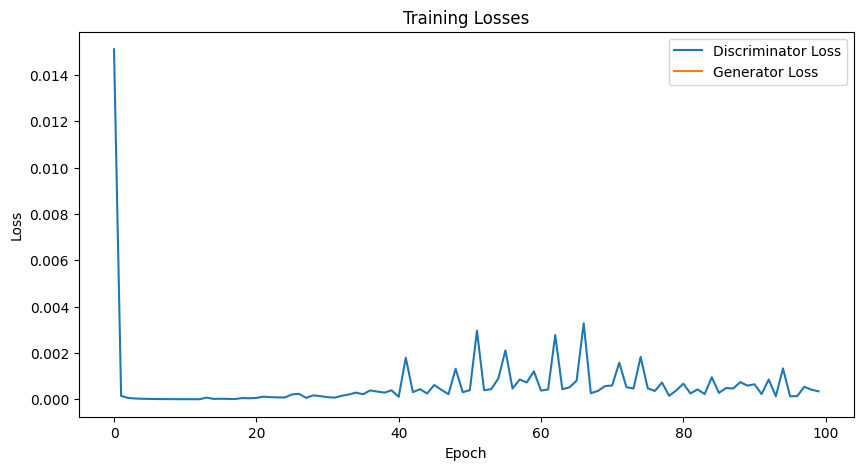

In [13]:
# Start by setting up the figure and axes for plotting with a specified size.
plt.figure(figsize=(10,5))

# Plot the discriminator's loss over epochs. The 'd_loss' values should have been logged in the `loss_history` callback
# and stored in a dictionary under the key 'd_loss'. Ensure this data is being populated correctly during training.
plt.plot(loss_history.losses['d_loss'], label="Discriminator Loss")

# Similarly, plot the generator's loss over epochs. The 'g_loss' values should also have been logged and stored
# under the key 'g_loss' in the same `loss_history` callback. As with the discriminator loss, verify that
# these values are correctly being recorded.
plt.plot(loss_history.losses['g_loss'], label="Generator Loss")

# Add a title to the plot for context.
plt.title("Training Losses")

# Label the x-axis as "Epoch" to indicate the progression of training over time.
plt.xlabel("Epoch")

# Label the y-axis as "Loss" to indicate the values being plotted represent the loss magnitude.
plt.ylabel("Loss")

# Include a legend to distinguish between the two plotted lines.
plt.legend()

# Display the plot.
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


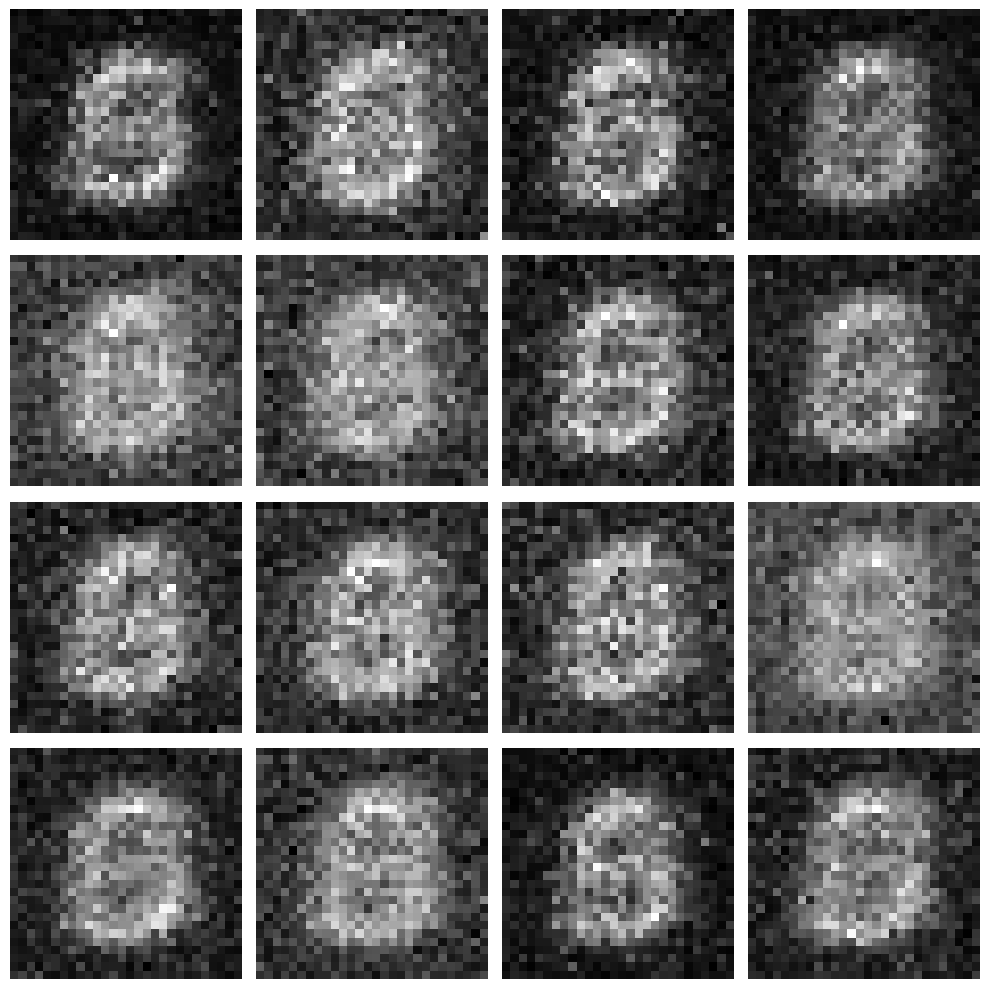

In [14]:
# Example for generating 16 noise samples for a generator expecting 100-dimensional input
z_size = 100  # Dimension of the generator's input vector
n = 4  # To generate n*n images
noise = np.random.normal(0, 1, (n * n, z_size))

generated_images = generator.predict(noise)

# Rescale images from [-1, 1] to [0, 1]
generated_images = 0.5 * generated_images + 0.5

# Function to display generated images
def show_generated_images(images, n=4):
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        img = images[i].reshape((28, 28))  # Ensure this matches your generator's output shape
        plt.subplot(n, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display images generated in the last step
show_generated_images(generated_images, n)